## Application: Wage and Education

#### Variables:

+ work - participation in 1975 ?
+ hoursw - wife's hours of work in 1975
+ child6 - number of children less than 6 years old in household
+ child618 - number of children between ages 6 and 18 in household
+ agew - wife's age
+ educw - wife's educational attainment, in years
+ hearnw - wife's average hourly earnings, in 1975 dollars
+ wagew - wife's wage reported at the time of the 1976 interview (not= 1975 estimated wage)
+ hoursh - husband's hours worked in 1975
+ ageh - husband's age
+ educh - husband's educational attainment, in years
+ wageh - husband's wage, in 1975 dollars
+ income - family income, in 1975 dollars
+ educwm - wife's mother's educational attainment, in years
+ educwf - wife's father's educational attainment, in years
+ unemprate - unemployment rate in county of residence, in percentage points
+ city - lives in large city (SMSA) ?
+ experience - actual years of wife's previous labor market experience

#### Source:

Mroz - Labor Supply Data

https://vincentarelbundock.github.io/Rdatasets/datasets.html

Mroz, T. (1987) “The sensitivity of an empirical model of married women's hours of work to economic and statistical assumptions”, Econometrica, 55, 765-799.


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
from IPython.display import display
from numpy.linalg import lstsq
# workaround for Theano compilation errors
import theano
theano.config.gcc.cxxflags = '-Wno-c++11-narrowing'

#### Data retrieval

`read_csv` creates a Pandas dataframe by retrieving data from a CSV file.

```Python
    read_csv(file name, option 1, option 2, ...)
```

`index_col=0` implies that the first column of the CSV file is used as the index of observations.


In [2]:
data = pd.read_csv('Mroz.csv', index_col=0)
wage = data['wagew'].values
educ = data['educw'].values
y = wage[wage > 0]
x = educ[wage > 0] - 12
ols_b = lstsq(np.vstack((np.ones(x.size), x)).T, y, rcond=None)[0]

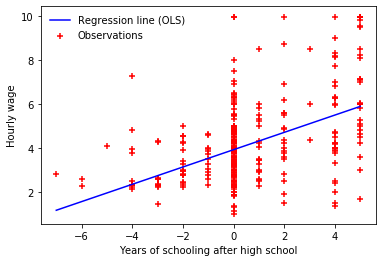

In [3]:
fig1 = plt.figure(num=1, facecolor='w')
plt.scatter(x, y, color='r', marker='+', label='Observations')
x_range = (np.min(x), np.max(x))
y_range = (ols_b[0] + ols_b[1]*x_range[0], ols_b[0] + ols_b[1]*x_range[1])
plt.plot(x_range, y_range, 'b-', label='Regression line (OLS)')
plt.xlabel('Years of schooling after high school')
plt.ylabel('Hourly wage')
plt.legend(loc='upper left', frameon=False)
# plt.savefig('ms_fig_wage_education.png', dpi=300)
plt.show()

In [4]:
mu_a = 0.0
mu_b = 0.0
omega_a = 10.0
omega_b = 10.0
nu0 = 0.02
lam0 = 0.02

In [5]:
regresssion_normal_invgamma = pm.Model()
with regresssion_normal_invgamma:
    sigma2 = pm.InverseGamma('sigma2', alpha=0.5*nu0, beta=0.5*lam0)
    a = pm.Normal('a', mu=mu_a, sd=omega_a)
    b = pm.Normal('b', mu=mu_b, sd=omega_b)
    y_hat = a + b * x
    likelihood = pm.Normal('y', mu=y_hat, sd=pm.math.sqrt(sigma2), observed=y)

In [6]:
n_draws = 5000
n_chains = 4
n_tune = 1000
with regresssion_normal_invgamma:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma2]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [00:03<00:00, 6447.50draws/s]


In [7]:
post_stats = pm.summary(trace)
post_stats.index = ['constant', 'education', '$\\sigma^2$']
display(post_stats)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
constant,3.914,0.096,3.732,4.091,0.001,0.000,22856.0,22856.0,22860.0,14975.0,1.0
education,0.394,0.041,0.318,0.472,0.000,0.000,23747.0,23566.0,23737.0,15697.0,1.0
$\sigma^2$,2.813,0.224,2.401,3.230,0.001,0.001,25648.0,25133.0,25901.0,14483.0,1.0


/Users/teruo/.pyenv/versions/miniconda3-latest/envs/bayes/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/teruo/.pyenv/versions/miniconda3-latest/envs/bayes/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/teruo/.pyenv/versions/miniconda3-latest/envs/bayes/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


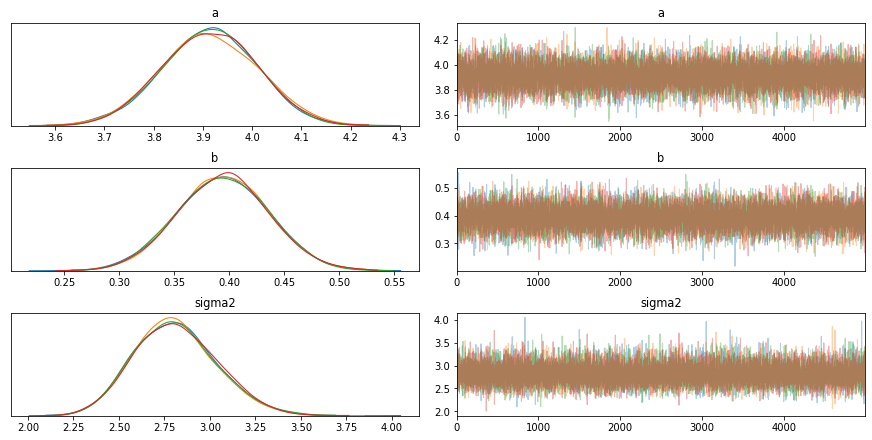

In [8]:
pm.traceplot(trace)
plt.show()

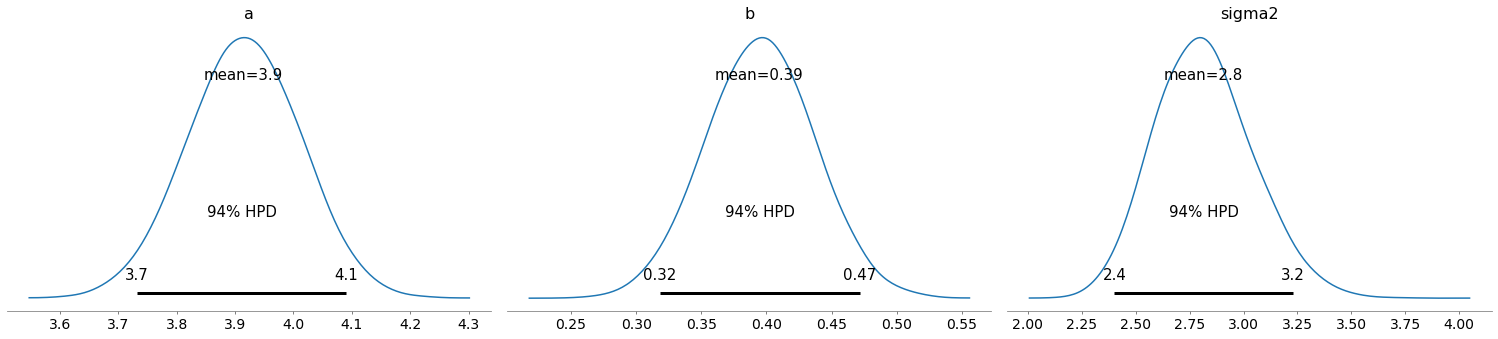

In [9]:
pm.plot_posterior(trace, kind='kde', point_estimate='mean')
plt.show()